<a href="https://colab.research.google.com/github/sriTechProjects/MDM_Data_Science/blob/main/Predictive_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Mounted at /content/drive
Starting Text-to-Image VQ-VAE training...
Loading saved VQ-VAE model...
Loaded model from epoch 75
Loading saved Text-to-Latent projector...
Loaded projector from epoch 40

Generating images from example prompts...


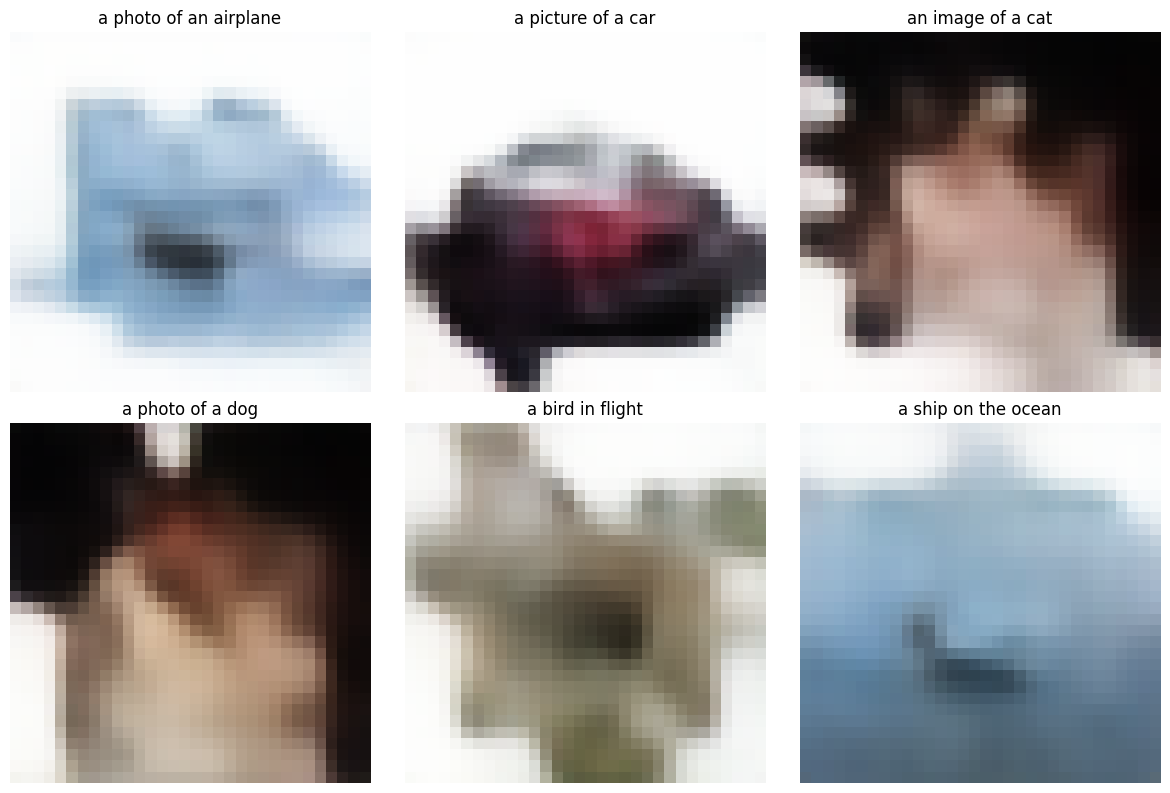


Generating creative variations...


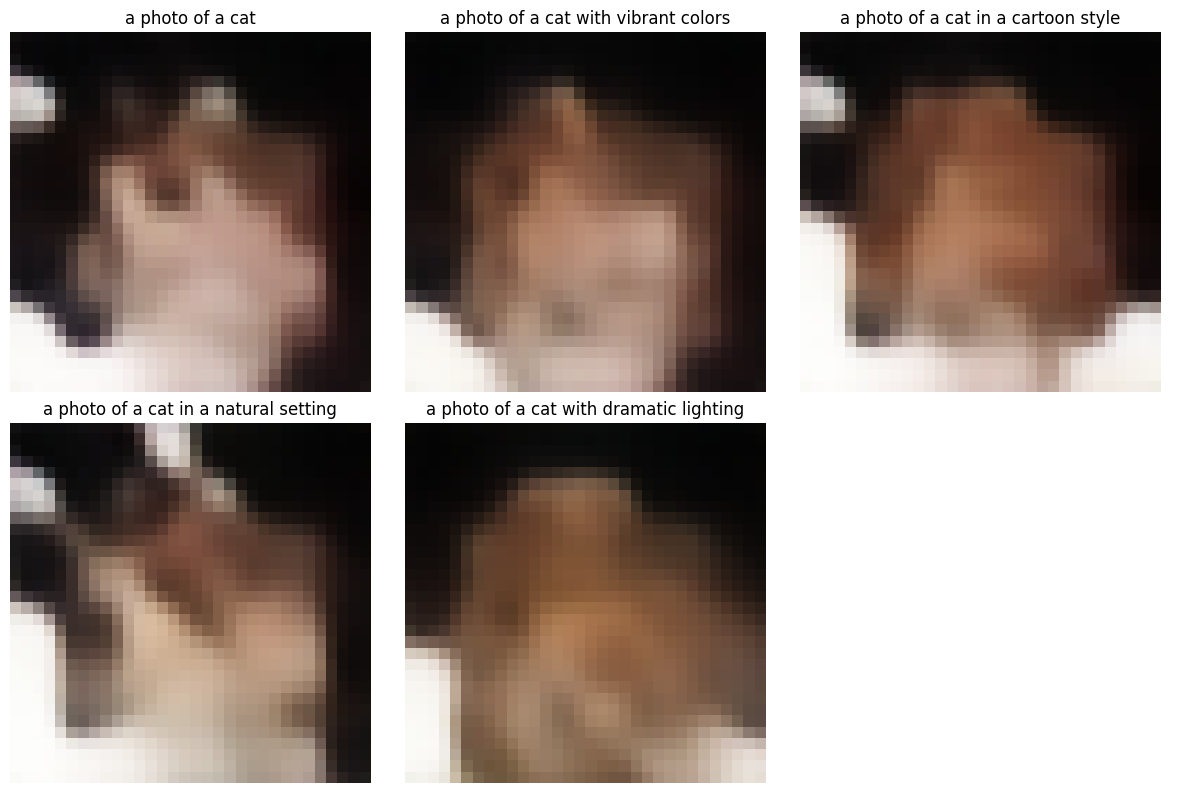


Entering interactive mode. Type 'quit' to exit.


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import random
import time
from transformers import DistilBertModel, DistilBertTokenizer
from google.colab import drive

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Install required packages if not already installed
try:
    from transformers import DistilBertModel
except ImportError:
    !pip install transformers

# Mount Google Drive for model saving/loading
drive.mount('/content/drive', force_remount=True)
MODEL_SAVE_PATH = '/content/drive/MyDrive/vqvae_text2img_model'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Configuration
class Config:
    # Dataset
    dataset_name = "cifar10"  # A small, lightweight dataset with common objects
    img_size = 32  # CIFAR10 images are 32x32

    # VQ-VAE
    num_embeddings = 512  # Size of codebook (number of latent codes)
    embedding_dim = 64   # Dimension of each latent code
    commitment_cost = 0.25  # Commitment loss weight

    # Training
    batch_size = 128
    learning_rate = 3e-4
    num_epochs = 75  # Increased from 30 to 75 for better convergence
    projector_epochs = 40  # Separate epoch count for text-to-latent training
    early_stopping_patience = 10  # Stop training if no improvement for this many epochs

    # Text encoder
    text_embedding_dim = 768  # DistilBERT hidden dimension

    # Text-to-latent projector
    hidden_dim = 256

    # Categories allowed for text prompts (CIFAR-10 classes)
    categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # Max prompt length (in tokens)
    max_prompt_length = 16

    # Validation split
    val_split = 0.1  # Use 10% of training data for validation

config = Config()

# Load and prepare dataset
def get_dataset():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    full_train_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    # Create validation split
    val_size = int(len(full_train_dataset) * config.val_split)
    train_size = len(full_train_dataset) - val_size

    train_dataset, val_dataset = torch.utils.data.random_split(
        full_train_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )

    test_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False
    )

    return train_loader, val_loader, test_loader, full_train_dataset.classes

# Define VQ-VAE components
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        # Initialize embeddings (codebook)
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def forward(self, inputs):
        # Convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self.embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()  # Straight-through estimator

        # Convert quantized from BHWC -> BCHW
        return quantized.permute(0, 3, 1, 2).contiguous(), loss, encoding_indices.view(input_shape[0], input_shape[1], input_shape[2])

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

        # If the number of input channels is different from output, we need to project
        self.skip = None
        if in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        residual = x

        out = self.relu(self.conv1(x))
        out = self.conv2(out)

        if self.skip is not None:
            residual = self.skip(x)

        out += residual
        out = self.relu(out)

        return out

class Encoder(nn.Module):
    def __init__(self, in_channels=3, embedding_dim=64):
        super(Encoder, self).__init__()

        # Initial convolution
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1)

        # Residual blocks
        self.res1 = ResidualBlock(32, 32)
        self.res2 = ResidualBlock(32, 64)

        # Downsampling
        self.conv2 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1)

        # Final convolution to embedding_dim
        self.final_conv = nn.Conv2d(64, embedding_dim, kernel_size=3, padding=1)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.res1(x)
        x = self.res2(x)
        x = self.relu(self.conv2(x))
        x = self.final_conv(x)
        return x

class Decoder(nn.Module):
    def __init__(self, out_channels=3, embedding_dim=64):
        super(Decoder, self).__init__()

        # Initial convolution
        self.conv1 = nn.Conv2d(embedding_dim, 64, kernel_size=3, padding=1)

        # Residual blocks
        self.res1 = ResidualBlock(64, 64)
        self.res2 = ResidualBlock(64, 32)

        # Upsampling
        self.upsample1 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.upsample2 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1)

        # Final convolution
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=3, padding=1)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.res1(x)
        x = self.relu(self.upsample1(x))
        x = self.res2(x)
        x = self.relu(self.upsample2(x))
        x = torch.tanh(self.final_conv(x))
        return x

class VQVAE(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VQVAE, self).__init__()

        self.encoder = Encoder(embedding_dim=embedding_dim)
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = Decoder(embedding_dim=embedding_dim)

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, indices = self.vq_layer(z)
        x_recon = self.decoder(quantized)

        return x_recon, vq_loss, indices

    def encode(self, x):
        z = self.encoder(x)
        quantized, _, indices = self.vq_layer(z)
        return indices

    def decode(self, indices):
        # Convert indices to one-hot
        batch_size, height, width = indices.shape
        one_hot = torch.zeros(batch_size, height, width, self.vq_layer.num_embeddings, device=indices.device)
        one_hot.scatter_(3, indices.unsqueeze(-1), 1)

        # Multiply by embedding weights
        quantized = torch.matmul(one_hot, self.vq_layer.embedding.weight)
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        # Decode
        return self.decoder(quantized)

# Text Encoder using DistilBERT
class TextEncoder:
    def __init__(self):
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.model.to(device)
        self.model.eval()  # Set to evaluation mode as we're not training this model

    def encode(self, text, max_length=16):
        # Tokenize and convert to tensors
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            padding="max_length",
            max_length=max_length,
            truncation=True
        )

        # Move inputs to device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get embeddings (no gradient needed as we're not training the text encoder)
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Use [CLS] token embedding as text representation
        text_embedding = outputs.last_hidden_state[:, 0, :]

        return text_embedding

# Text-to-Latent Projector
class TextToLatentProjector(nn.Module):
    def __init__(self, text_dim, hidden_dim, latent_height, latent_width, num_embeddings):
        super(TextToLatentProjector, self).__init__()

        self.latent_height = latent_height
        self.latent_width = latent_width
        self.num_embeddings = num_embeddings

        # Projection network: text embedding -> spatial latent indices
        self.projector = nn.Sequential(
            nn.Linear(text_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_height * latent_width * num_embeddings),
        )

    def forward(self, text_embedding):
        batch_size = text_embedding.shape[0]

        # Project text embedding to flattened latent indices probabilities
        logits = self.projector(text_embedding)

        # Reshape to [batch_size, height, width, num_embeddings]
        logits = logits.view(batch_size, self.latent_height, self.latent_width, self.num_embeddings)

        # For training: return logits for cross-entropy loss
        return logits

    def generate_indices(self, text_embedding):
        logits = self.forward(text_embedding)

        # Get the most likely indices at each position
        indices = torch.argmax(logits, dim=-1)

        return indices

# Validation function for VQ-VAE
def validate_vqvae(model, val_loader):
    model.eval()
    val_recon_error = 0
    val_perplexity = 0

    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)

            recon_batch, vq_loss, indices = model(data)
            recon_error = F.mse_loss(recon_batch, data)

            # Calculate perplexity
            encodings = torch.zeros(indices.shape + (model.vq_layer.num_embeddings,), device=device)
            encodings.scatter_(-1, indices.unsqueeze(-1), 1)
            avg_probs = encodings.view(-1, model.vq_layer.num_embeddings).mean(0)
            perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

            val_recon_error += recon_error.item()
            val_perplexity += perplexity.item()

    val_recon_error /= len(val_loader)
    val_perplexity /= len(val_loader)

    model.train()
    return val_recon_error, val_perplexity

# Train the VQ-VAE model with improved training loop
def train_vqvae(model, train_loader, val_loader, optimizer, num_epochs):
    model.train()
    train_res_recon_error = []
    train_res_perplexity = []
    val_res_recon_error = []
    val_res_perplexity = []

    # Learning rate scheduler based on validation loss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    # Early stopping
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        train_recon_error = 0
        train_perplexity = 0

        for data, _ in tqdm(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            recon_batch, vq_loss, indices = model(data)
            recon_error = F.mse_loss(recon_batch, data)
            loss = recon_error + vq_loss

            loss.backward()
            optimizer.step()

            train_recon_error += recon_error.item()

            # Calculate perplexity (effective codebook usage)
            with torch.no_grad():
                encodings = torch.zeros(indices.shape + (model.vq_layer.num_embeddings,), device=device)
                encodings.scatter_(-1, indices.unsqueeze(-1), 1)
                avg_probs = encodings.view(-1, model.vq_layer.num_embeddings).mean(0)
                perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
                train_perplexity += perplexity.item()

        # Calculate average error and perplexity for epoch
        train_recon_error /= len(train_loader)
        train_perplexity /= len(train_loader)

        # Run validation
        val_recon_error, val_perplexity = validate_vqvae(model, val_loader)

        # Store metrics
        train_res_recon_error.append(train_recon_error)
        train_res_perplexity.append(train_perplexity)
        val_res_recon_error.append(val_recon_error)
        val_res_perplexity.append(val_perplexity)

        # Step scheduler with validation loss
        scheduler.step(val_recon_error)

        # Early stopping check
        if val_recon_error < best_val_loss:
            best_val_loss = val_recon_error
            best_epoch = epoch
            patience_counter = 0

            # Save best model
            torch.save({
                'vqvae_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_val_loss': best_val_loss
            }, os.path.join(MODEL_SAVE_PATH, 'vqvae_model_best.pth'))
        else:
            patience_counter += 1

        print(f'Epoch {epoch+1}: '
              f'Train Recon Error: {train_recon_error:.4f}, Train Perplexity: {train_perplexity:.2f} | '
              f'Val Recon Error: {val_recon_error:.4f}, Val Perplexity: {val_perplexity:.2f}')

        # Early stopping
        if patience_counter >= config.early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}. Best epoch was {best_epoch+1}.')
            break

        # Periodically test and visualize reconstructions
        if (epoch + 1) % 5 == 0 or epoch == 0:
            model.eval()
            with torch.no_grad():
                data, _ = next(iter(val_loader))
                data = data[:8].to(device)  # Use just 8 images
                recon_batch, _, _ = model(data)

                # Denormalize images
                data = (data + 1) / 2
                recon_batch = (recon_batch + 1) / 2

                # Create grid of original and reconstructed images
                comparison = torch.cat([data, recon_batch])
                grid = make_grid(comparison.cpu(), nrow=8)
                plt.figure(figsize=(12, 6))
                plt.imshow(grid.permute(1, 2, 0))
                plt.title(f'Epoch {epoch+1} - Top: Original, Bottom: Reconstruction')
                plt.axis('off')
                plt.show()
            model.train()

    # Load best model
    best_model = torch.load(os.path.join(MODEL_SAVE_PATH, 'vqvae_model_best.pth'))
    model.load_state_dict(best_model['vqvae_state_dict'])

    # Save final model state
    torch.save({
        'vqvae_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': num_epochs,
        'train_recon_error': train_res_recon_error,
        'train_perplexity': train_res_perplexity,
        'val_recon_error': val_res_recon_error,
        'val_perplexity': val_res_perplexity
    }, os.path.join(MODEL_SAVE_PATH, 'vqvae_model_final.pth'))

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_res_recon_error, label='Train')
    plt.plot(val_res_recon_error, label='Validation')
    plt.title('Reconstruction Error')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_res_perplexity, label='Train')
    plt.plot(val_res_perplexity, label='Validation')
    plt.title('Perplexity (Codebook Usage)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return train_res_recon_error, train_res_perplexity, val_res_recon_error, val_res_perplexity

# Validation function for text-to-latent projector
def validate_text2latent(vqvae, projector, text_encoder, val_loader, criterion):
    projector.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            # Extract batch data
            images = batch[0]  # List of images
            texts = batch[1]   # List of texts

            # Convert list of images to tensor batch
            if isinstance(images[0], torch.Tensor):
                images = torch.stack(images).to(device)
            else:
                # Handle if images are not tensors (unlikely but safe)
                images = torch.stack([torch.tensor(img) for img in images]).to(device)

            # Encode texts
            text_embeddings = text_encoder.encode(texts)

            # Extract true latent indices from images using the VQ-VAE
            _, _, true_indices = vqvae(images)

            # Project text embeddings to latent space
            logits = projector(text_embeddings)

            # Calculate loss
            batch_size, height, width, num_embeddings = logits.shape

            # Reshape for cross-entropy loss
            logits = logits.view(batch_size * height * width, num_embeddings)
            targets = true_indices.view(batch_size * height * width)

            loss = criterion(logits, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    projector.train()
    return val_loss

# Create text-to-image paired dataset
class Text2ImageDataset(Dataset):
    def __init__(self, image_dataset, classes, text_encoder):
        self.image_dataset = image_dataset
        self.classes = classes
        self.text_encoder = text_encoder

        # Templates for text prompts - expanded for more variety
        self.templates = [
            "a photo of a {}",
            "a picture of a {}",
            "an image of a {}",
            "a {} in a photo",
            "this is a {}",
            "this is a photo of a {}",
            "a clear picture of a {}",
            "a rendering of a {}",
            "a cropped photo of a {}",
            "a close-up of a {}"
        ]

    def __len__(self):
        return len(self.image_dataset)

    def __getitem__(self, idx):
        image, label = self.image_dataset[idx]
        class_name = self.classes[label]

        # Generate text prompt using random template
        template = random.choice(self.templates)
        text = template.format(class_name)

        return image, text, label

# Train the Text-to-Latent Projector with improved training loop
def train_text2latent(vqvae, projector, text_encoder, train_loader, val_loader, optimizer, num_epochs):
    vqvae.eval()  # VQ-VAE is frozen during this training
    projector.train()

    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Early stopping
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        train_loss = 0

        for batch in tqdm(train_loader):
            # Extract batch data
            images = batch[0]  # List of images
            texts = batch[1]   # List of texts

            # Convert list of images to tensor batch
            if isinstance(images[0], torch.Tensor):
                images = torch.stack(images).to(device)
            else:
                # Handle if images are not tensors (unlikely but safe)
                images = torch.stack([torch.tensor(img) for img in images]).to(device)

            # Encode texts
            text_embeddings = text_encoder.encode(texts)

            # Extract true latent indices from images using the VQ-VAE
            with torch.no_grad():
                _, _, true_indices = vqvae(images)

            # Project text embeddings to latent space
            logits = projector(text_embeddings)

            # Calculate loss
            batch_size, height, width, num_embeddings = logits.shape

            # Reshape for cross-entropy loss
            logits = logits.view(batch_size * height * width, num_embeddings)
            targets = true_indices.view(batch_size * height * width)

            loss = criterion(logits, targets)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Average loss for the epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validate
        val_loss = validate_text2latent(vqvae, projector, text_encoder, val_loader, criterion)
        val_losses.append(val_loss)

        # Step scheduler
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0

            # Save best model
            torch.save({
                'projector_state_dict': projector.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_val_loss': best_val_loss
            }, os.path.join(MODEL_SAVE_PATH, 'text2latent_model_best.pth'))
        else:
            patience_counter += 1

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Early stopping
        if patience_counter >= config.early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}. Best epoch was {best_epoch+1}.')
            break

        # Periodically test the projector
        if (epoch + 1) % 5 == 0 or epoch == 0:
            projector.eval()
            with torch.no_grad():
                # Get a batch of data
                sample_batch = next(iter(val_loader))
                sample_images = torch.stack(sample_batch[0][:4]).to(device)  # Use just 4 samples
                sample_texts = sample_batch[1][:4]  # Use the same 4 samples for texts

                # Encode texts
                text_embeddings = text_encoder.encode(sample_texts)

                # Generate indices from text
                generated_indices = projector.generate_indices(text_embeddings)

                # Get true indices from images
                _, _, true_indices = vqvae(sample_images)

                # Calculate accuracy
                accuracy = (generated_indices == true_indices).float().mean().item() * 100

                # Decode indices to images
                generated_images = vqvae.decode(generated_indices)
                true_reconstructions = vqvae.decode(true_indices)

                # Display original images, true reconstructions, and text-generated images
                fig, axes = plt.subplots(4, 3, figsize=(15, 10))
                for i, (text, orig, true_recon, gen_img) in enumerate(zip(sample_texts, sample_images, true_reconstructions, generated_images)):
                    # Convert tensors to images
                    orig = (orig.cpu() + 1) / 2
                    true_recon = (true_recon.cpu() + 1) / 2
                    gen_img = (gen_img.cpu() + 1) / 2

                    # Display
                    axes[i, 0].imshow(orig.permute(1, 2, 0))
                    axes[i, 0].set_title('Original')
                    axes[i, 0].axis('off')

                    axes[i, 1].imshow(true_recon.permute(1, 2, 0))
                    axes[i, 1].set_title('True Reconstruction')
                    axes[i, 1].axis('off')

                    axes[i, 2].imshow(gen_img.permute(1, 2, 0))
                    axes[i, 2].set_title(f'From Text: "{text}"')
                    axes[i, 2].axis('off')

                plt.tight_layout()
                plt.suptitle(f'Epoch {epoch+1} - Index Matching Accuracy: {accuracy:.2f}%')
                plt.subplots_adjust(top=0.9)
                plt.show()

            projector.train()

    # Load best model
    best_model = torch.load(os.path.join(MODEL_SAVE_PATH, 'text2latent_model_best.pth'))
    projector.load_state_dict(best_model['projector_state_dict'])

    # Save final model state
    torch.save({
        'projector_state_dict': projector.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': num_epochs,
        'train_loss': train_losses,
        'val_loss': val_losses
    }, os.path.join(MODEL_SAVE_PATH, 'text2latent_model_final.pth'))

    # Plot training curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Text-to-Latent Projector Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return train_losses, val_losses

# Function to generate images from text
def generate_images_from_text(vqvae, projector, text_encoder, prompts, num_rows=2):
    vqvae.eval()
    projector.eval()

    # Encode texts
    text_embeddings = text_encoder.encode(prompts)

    # Generate latent indices from text embeddings
    with torch.no_grad():
        generated_indices = projector.generate_indices(text_embeddings)

        # Decode indices to images
        generated_images = vqvae.decode(generated_indices)

        # Denormalize
        generated_images = (generated_images + 1) / 2

    # Display generated images with their prompts
    num_cols = (len(prompts) + num_rows - 1) // num_rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, (prompt, img) in enumerate(zip(prompts, generated_images)):
        if i < len(axes):
            axes[i].imshow(img.cpu().permute(1, 2, 0))
            axes[i].set_title(prompt)
            axes[i].axis('off')

    # Hide any unused subplots
    for j in range(len(prompts), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    return generated_images

# Function to add creative variations to a prompt
def creative_prompt_variations(base_prompt, num_variations=4):
    templates = [
        "{} with vibrant colors",
        "{} in a cartoon style",
        "{} in a natural setting",
        "{} with dramatic lighting",
        "{} viewed from above",
        "{} in the style of a painting",
        "{} with intricate details",
        "{} against a simple background"
    ]

    variations = []
    for i in range(min(num_variations, len(templates))):
        variations.append(templates[i].format(base_prompt))

    return variations

# Main execution code
def main():
    print("Starting Text-to-Image VQ-VAE training...")

    # Get datasets and dataloaders
    train_loader, val_loader, test_loader, classes = get_dataset()

    # Initialize VQ-VAE
    vqvae = VQVAE(
        num_embeddings=config.num_embeddings,
        embedding_dim=config.embedding_dim,
        commitment_cost=config.commitment_cost
    ).to(device)

    # Initialize optimizer for VQ-VAE
    vqvae_optimizer = optim.Adam(vqvae.parameters(), lr=config.learning_rate)

    # Check if a saved model exists
    vqvae_checkpoint_path = os.path.join(MODEL_SAVE_PATH, 'vqvae_model_final.pth')
    if os.path.exists(vqvae_checkpoint_path):
        print("Loading saved VQ-VAE model...")
        checkpoint = torch.load(vqvae_checkpoint_path)
        vqvae.load_state_dict(checkpoint['vqvae_state_dict'])
        train_recon_error = checkpoint.get('train_recon_error', [])
        val_recon_error = checkpoint.get('val_recon_error', [])
        print(f"Loaded model from epoch {checkpoint.get('epoch', 'unknown')}")
    else:
        print("Training VQ-VAE model...")
        train_recon_error, train_perplexity, val_recon_error, val_perplexity = train_vqvae(
            vqvae, train_loader, val_loader, vqvae_optimizer, config.num_epochs
        )

    # Initialize text encoder
    text_encoder = TextEncoder()

    # Create text-to-image datasets
    train_dataset = Text2ImageDataset(
        train_loader.dataset,
        classes=config.categories,
        text_encoder=text_encoder
    )

    val_dataset = Text2ImageDataset(
        val_loader.dataset,
        classes=config.categories,
        text_encoder=text_encoder
    )

    # Create dataloaders for text-to-image pairs
    text2img_train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        collate_fn=lambda batch: ([item[0] for item in batch], [item[1] for item in batch], [item[2] for item in batch])
    )

    text2img_val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=lambda batch: ([item[0] for item in batch], [item[1] for item in batch], [item[2] for item in batch])
    )

    # Initialize Text-to-Latent Projector
    # Calculate the latent dimensions (output size of encoder)
    with torch.no_grad():
        sample_image = next(iter(train_loader))[0][0:1].to(device)
        latent = vqvae.encoder(sample_image)
        latent_height, latent_width = latent.shape[2], latent.shape[3]

    projector = TextToLatentProjector(
        text_dim=config.text_embedding_dim,
        hidden_dim=config.hidden_dim,
        latent_height=latent_height,
        latent_width=latent_width,
        num_embeddings=config.num_embeddings
    ).to(device)

    # Initialize optimizer for projector
    projector_optimizer = optim.Adam(projector.parameters(), lr=config.learning_rate)

    # Check if a saved projector exists
    projector_checkpoint_path = os.path.join(MODEL_SAVE_PATH, 'text2latent_model_final.pth')
    if os.path.exists(projector_checkpoint_path):
        print("Loading saved Text-to-Latent projector...")
        checkpoint = torch.load(projector_checkpoint_path)
        projector.load_state_dict(checkpoint['projector_state_dict'])
        train_loss = checkpoint.get('train_loss', [])
        val_loss = checkpoint.get('val_loss', [])
        print(f"Loaded projector from epoch {checkpoint.get('epoch', 'unknown')}")
    else:
        print("Training Text-to-Latent projector...")
        train_loss, val_loss = train_text2latent(
            vqvae, projector, text_encoder, text2img_train_loader, text2img_val_loader,
            projector_optimizer, config.projector_epochs
        )

    # Generate images from example prompts
    print("\nGenerating images from example prompts...")
    example_prompts = [
        "a photo of an airplane",
        "a picture of a car",
        "an image of a cat",
        "a photo of a dog",
        "a bird in flight",
        "a ship on the ocean"
    ]
    generate_images_from_text(vqvae, projector, text_encoder, example_prompts)

    # Generate creative variations
    print("\nGenerating creative variations...")
    base_prompt = "a photo of a cat"
    variations = creative_prompt_variations(base_prompt)
    generate_images_from_text(vqvae, projector, text_encoder, [base_prompt] + variations)

    # Interactive mode
    print("\nEntering interactive mode. Type 'quit' to exit.")
    while True:
        user_prompt = input("\nEnter a text prompt: ")
        if user_prompt.lower() == 'quit':
            break

        # Generate and display image
        generate_images_from_text(vqvae, projector, text_encoder, [user_prompt])

    print("Text-to-Image VQ-VAE program completed successfully!")

if __name__ == "__main__":
    main()